<a href="https://colab.research.google.com/github/JakeFiler/fromTheGround/blob/main/firstSteps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is to serve as the first real steps into the world of neural networks. The goal of this notebook specifically is to understand how a neural network works at its core, and why it works in that way.

In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Math Review

In [ ]:
#Quadratic function for a parabola
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
#where x is 3.0 where

f(3.0)

20.0

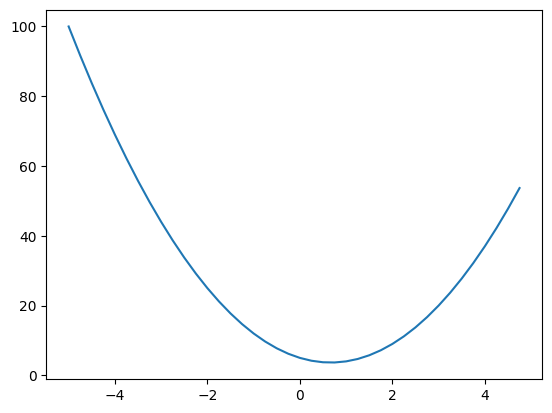

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)




The **derivative** represents the rate of change of a function.

**Differentiation** is the process of finding that derivative.

Below is **numeric differentiation** of a function f(x) where x = 2/3

In [ ]:
h = 0.000000001 # bring this closer to zero and converge to the exact amount (run)
x = 2/3 # the point at which im interested in the derivative of the funciton
f(x+h) # change x an very small amount
f(x+h)-f(x) # what happened to x beacuse of the changes applied by h? (this is the rise)
(f(x+h)-f(x))/h # the approximation of the slope of the tangent line or the IRC(rise/run)

0.0

In [ ]:
# A function with mutltiple inputs
a = 2.0
b = -3.0
c = 10.0
d = a*b + c

print(d)

4.0


In [ ]:
h = 0.000000001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print(d1)
print(d2)
print((d2 - d1)/h)

4.0
3.9999999969999998
-3.000000248221113


# Value Class

Each operation on a Value (such as addition or multiplication) creates a new Value object that:
- stores the computed result
- keeps track of its parent nodes
- a _backward function that defines how the gradient of the output is distributed to the inputs based on the chain rule


This class encapsulates a single scalar value and its gradient. It also stores:
- `data`: The actual numerical value.
- `grad`: The gradient of the final output with respect to this value (initially `0`).
- `_prev`: A set of parent nodes (used to track dependencies for backprop).
- `_op`: The operation that created this value (`+`, `*`, or `tanh`).
- `_backward`: A function that, when called, applies the chain rule to update gradients of parent nodes.

When we call `backward()` on a final node, it:
1. Builds a topological ordering of the nodes (so we can process them in reverse).
2. Sets the gradient of the final node to 1 (since d(output)/d(output) = 1).
3. Propagates gradients backward through the graph by repeatedly calling `_backward()` on each node.

In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()




In [1]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label ='f')
L = d * f; L.label = 'L'
L

NameError: name 'Value' is not defined

This is giving the children of the d
(value resulting from a*b) and c

In [ ]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

The **operation** used to get the value

In [ ]:
d._op

'+'

# Graphing
Visualizes the computation graph (DAG) used for automatic differentiation

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

This is the visualization of the **Forward Pass**

In [ ]:
draw_dot(L)

In [ ]:
#nudging the leaf nodes in some direction to see what happens to L
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print (L.data)

-7.800800000000001


#Manual Backpropagation

We want to know the derivitive of d with respect to L in the above graph

L = d * f

dL/dd = f


```
the proof
(f(x+h)-f(x))/h
(d+h)*f - d*f / h
df + hf - df / h  -> df-df cancels
hf/h
f

```

The derivative of d with respect to L is f

The derivative of f with respect to L is d


In [ ]:
L.grad = 1.0
d.grad = -2.0 #f
f.grad = 4    #d

In [ ]:
c.grad = -2   #feed backwards since addition operation
e.grad = -2   #feed backwards since addition operation

## Chain Rule Time


**For any composite function, the overall derivative is the product of the derivatives along the chain.**

If a car is twice as fast as a bike, and a bike is 4 times as fast as a walking man, then the car travels 8 times faster than the man

z = car

y = bicycle

x = man

The rate of change of the relative positions of the car and the walking man is equal to the rate of change of the relative positions of car to the bike times the bike to the man.

dz/dy = 2 (car is 2 times as fast as the bike).

dy/dx = 4 (bike is 4 times as fast as the man).

Therefore, dz/dx = 2 * 4 = 8 (car is 8 times as fast as the man).

The important part here is how can we get the derivitive of L with respect to c

How is L sensitive to c

If we can figure out how c impacts d, then how d impacts L then we should be able to get it

dd/dc = 1.0

dd/de = 1.0

d = c + e

WANT:

dL / dc = (dL / dd) * (dd / dc)

KNOW:

dL / dd = ?

dd / dc = 1.0




In [ ]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

dL / de = -2.0

e = a * b

de / da? b

dL / da = (dL / de) * (de / da)


In [ ]:
# Inline Gradient Check
# Deriving the backpropagation and getting the derivative with respect
# to all the intermidiate results
def lol():

  h = 0.00001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label ='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label ='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

-4.000000000026205


# Activation Functions

Squashing stuff

Your input could be anything form -inf to inf



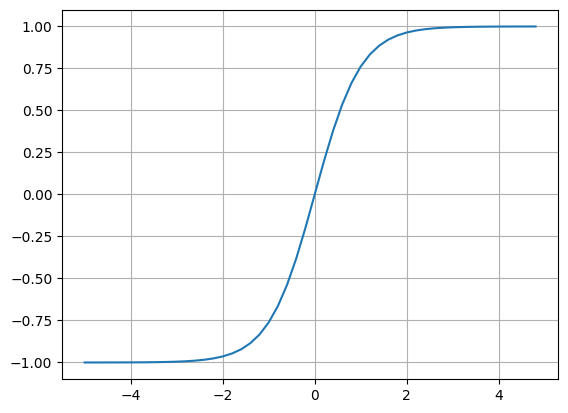

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [ ]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

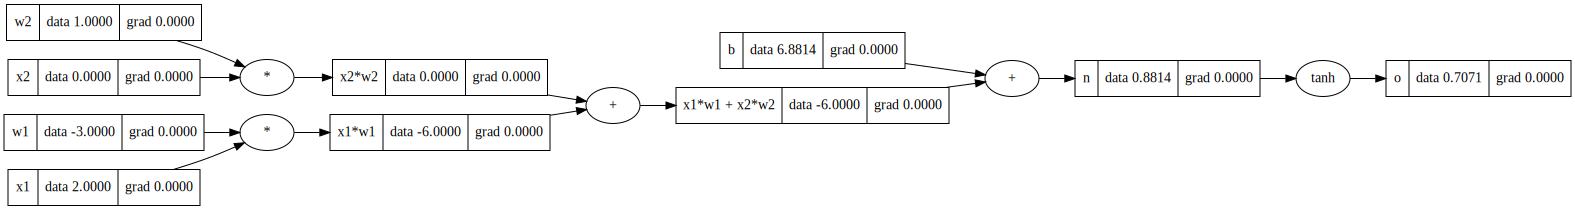

In [ ]:
draw_dot(o)

Run this and recheck graph above to see it backpropagate the gradients through the network

In [ ]:
o.backward()

In [ ]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'

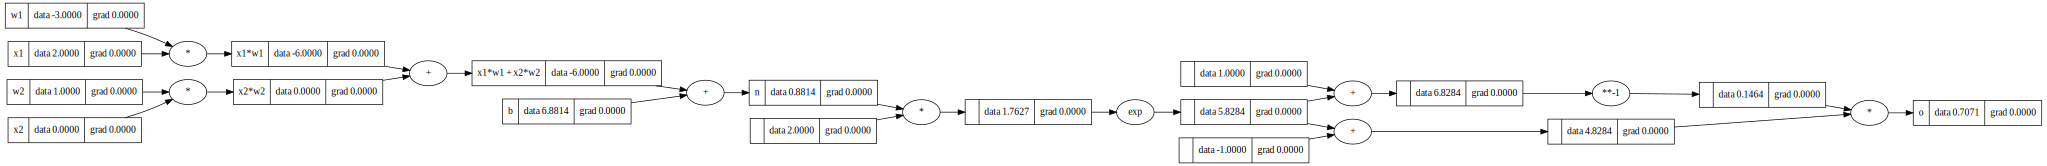

In [ ]:
draw_dot(o)

In [ ]:
o.backward()

Neuron: Basic unit that computes a weighted sum of inputs, adds a bias, and applies a non-linear activation.

Layer: A collection of neurons working together, transforming input data.

MLP: A multi-layer network that stacks layers to form a complete model, enabling complex function approximations and learning.

In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]



In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.8425679621078417)

In [ ]:
n.parameters()

[Value(data=0.35362848456510165),
 Value(data=-0.5253054635722798),
 Value(data=0.7039144007933873),
 Value(data=0.48333970195810183),
 Value(data=-0.706204776236274),
 Value(data=0.2859295047004693),
 Value(data=0.293364461898878),
 Value(data=0.364047744966838),
 Value(data=-0.529043933708554),
 Value(data=0.5881657958123121),
 Value(data=0.9959816229326106),
 Value(data=0.2515498359084669),
 Value(data=0.09389971313016376),
 Value(data=0.9840913276488306),
 Value(data=-0.22966770197328956),
 Value(data=0.6498305931578894),
 Value(data=-0.14302033141019077),
 Value(data=0.9544374808918554),
 Value(data=-0.22780442702885995),
 Value(data=0.47011196614822204),
 Value(data=-0.2840500985299872),
 Value(data=0.9904710623320732),
 Value(data=0.7450309514957252),
 Value(data=0.6608598786686417),
 Value(data=-0.03849562230691039),
 Value(data=0.045936283559048885),
 Value(data=-0.4836507725779662),
 Value(data=-0.2867871867235683),
 Value(data=-0.5799829328194834),
 Value(data=-0.19472919190

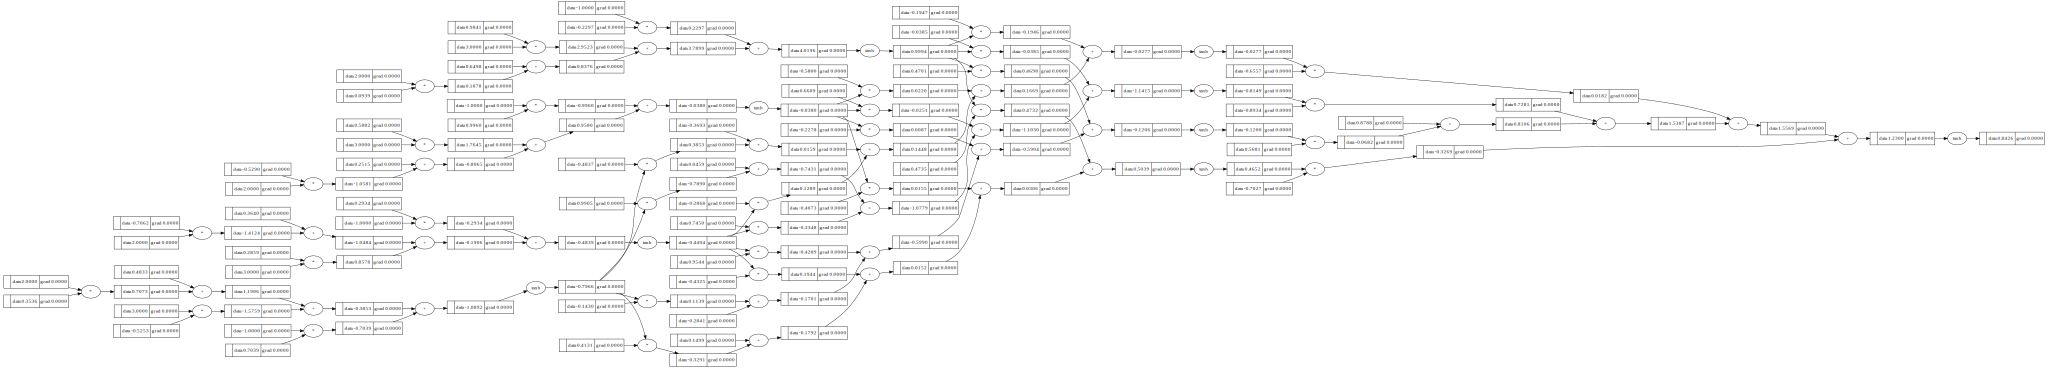

In [ ]:
draw_dot(n(x))

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [ ]:
# Gradient descent training loop
for k in range(25):

  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  #update
  for p in n.parameters():
    p.data += -0.5 * p.grad

  print(k, loss.data)




0 3.669994497376846
1 7.996499881423965
2 7.993041842119833
3 7.9709448223400905
4 7.60975085265574
5 0.0025304453467807847
6 0.0019697036501362146
7 0.0016159523035771575
8 0.001371371031402932
9 0.0011918019518508387
10 0.0010542081769517057
11 0.0009453395904903711
12 0.0008570147781021268
13 0.0007839007165016267
14 0.000722368771768006
15 0.0006698624233051848
16 0.000624527637210634
17 0.0005849866011415273
18 0.0005501937769904653
19 0.0005193412743674732
20 0.0004917948662941064
21 0.0004670496482893676
22 0.00044469863919160903
23 0.0004244101164620534
24 0.00040591097404663853


In [ ]:
ypred

[Value(data=0.9843521130832903),
 Value(data=-0.9993221195747845),
 Value(data=-0.9995888101911476),
 Value(data=0.9873340610234097)]